# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size =50 #experiment with the batch size

In [4]:
len(train_doc)

663

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[0,7,14,21,28] #create a list of image numbers you want to use for a particular video
    #img_idx =[0,3,7,11,14,17,21,25,29]
    #img_idx =[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29]
    x=len(img_idx)
    y=150
    z=150
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,[y,z])
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]-np.min(image[:,:,0]))/(np.max(image[:,:,0])-np.min(image[:,:,0])) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image[:,:,1]-np.min(image[:,:,1]))/(np.max(image[:,:,1])-np.min(image[:,:,1]))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]-np.min(image[:,:,2]))/(np.max(image[:,:,2])-np.min(image[:,:,2]))#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_size1=len(folder_list)-(folder + (batch*batch_size))-1
        rm_fld=folder + (batch*batch_size)+1
        for batch in range(1): # we iterate over the number of batches
            batch_data = np.zeros((batch_size1,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size1,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size1): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + rm_fld].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + rm_fld].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=resize(image,[y,z])
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]-np.min(image[:,:,0]))/(np.max(image[:,:,0])-np.min(image[:,:,0])) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image[:,:,1]-np.min(image[:,:,1]))/(np.max(image[:,:,1])-np.min(image[:,:,1]))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]-np.min(image[:,:,2]))/(np.max(image[:,:,2])-np.min(image[:,:,2]))#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + rm_fld].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
#img_idx =[0,3,7,11,14,17,21,25,29]
img_idx =[0,7,14,21,28]
#img_idx =[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29]
x=len(img_idx)
y=150
z=150
#write your model here
initializer = tf.keras.initializers.HeNormal()
model = Sequential()
model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same',input_shape=(y,z,x,3),kernel_initializer=initializer))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same',kernel_initializer=initializer))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))

#model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same',kernel_initializer=initializer))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
#model.add(BatchNormalization())
#Here
#model.add(MaxPooling3D(pool_size=(2,2,2),padding='same'))
#model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.02),kernel_initializer=initializer))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_regularizer=l2(0.02),kernel_initializer=initializer))
model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(Dense(5,kernel_initializer=initializer))
model.add(Activation('softmax'))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
import tensorflow as tf 
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
img_idx =[0,7,14,21,28]
#img_idx =[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,29]
x=len(img_idx)
y=150
z=150
initializer = tf.keras.initializers.HeNormal()
inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(y,z,3)
)
  
for layer in inceptionresnet.layers[:-9]:                                                       
    layer.trainable = False

model = Sequential()

model.add(TimeDistributed(inceptionresnet, input_shape=(x, y, z, 3)))     
                     
#Using TimeDistributed Layer to Feed the Image Sequence
# now, flatten  each output to send 8 outputs with one dimension to #LSTM
model.add( TimeDistributed( Flatten() ))

##Added LSTM to Capture the Sequencial Information
model.add(GRU (64,activation='relu', return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
#model.add(GRU (128, activation='relu', return_sequences=False))
model.add(GRU (128,activation='relu',return_sequences=False))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
#model.add(GRU (64, activation='relu', return_sequences=False))
# Dense Layer
model.add(Dense (256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.2))
#Final Dense Layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [8]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 3, 3, 1536)     54336736  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 13824)          0         
_________________________________________________________________
gru (GRU)                    (None, 5, 64)             2666880   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               74496     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
batch_normalization_203 (Bat (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [57]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 150, 150, 5, 32)   800       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 150, 150, 5, 32)   0         
_________________________________________________________________
batch_normalization_412 (Bat (None, 150, 150, 5, 32)   128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 75, 75, 2, 32)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 2, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 75, 75, 2, 64)     16448     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 75, 75, 2, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
#next(val_generator)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq = 'epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [62]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 82.0608 - categorical_accuracy: 0.2685Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss improved from inf to 38.97869, saving model to model_init_2022-03-3010_20_35.944125/model-00001-82.06079-0.26848-38.97869-0.32000.h5
14/14 [==============================] - 26s 2s/step - loss: 82.0608 - categorical_accuracy: 0.2685 - val_loss: 38.9787 - val_categorical_accuracy: 0.3200
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 34.9661 - categorical_accuracy: 0.5068
Epoch 00002: val_loss improved from 38.97869 to 32.44517, saving model to model_init_2022-03-3010_20_35.944125/model-00002-34.96609-0.50679-32.44517-0.33000.h5
14/14 [==============================] - 26s 2s/step - loss: 34.9661 - categorical_accuracy: 0.5068 - val_loss: 32.4452 - val_categorical_accuracy: 0.3300
Epoch 3/50
14/14 [===========

In [13]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.1636 - categorical_accuracy: 0.5173Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.44653, saving model to model_init_2022-03-3016_19_34.999011/model-00001-1.16355-0.51735-1.44653-0.40000.h5
14/14 [==============================] - 30s 2s/step - loss: 1.1636 - categorical_accuracy: 0.5173 - val_loss: 1.4465 - val_categorical_accuracy: 0.4000
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.5751 - categorical_accuracy: 0.8009
Epoch 00002: val_loss improved from 1.44653 to 1.15246, saving model to model_init_2022-03-3016_19_34.999011/model-00002-0.57512-0.80090-1.15246-0.55000.h5
14/14 [==============================] - 27s 2s/step - loss: 0.5751 - categorical_accuracy: 0.8009 - val_loss: 1.1525 - val_categorical_accuracy: 0.5500
Epoch 3/50
14/14 [========================

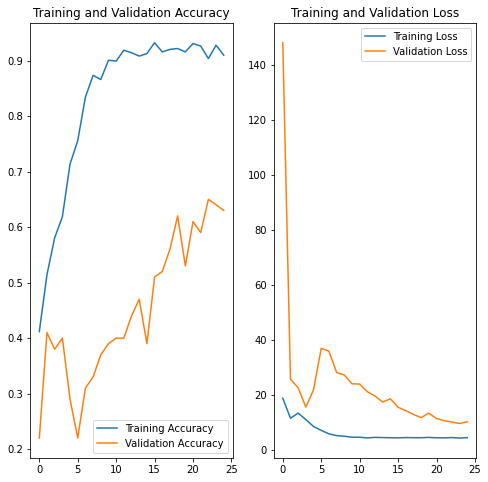

In [70]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

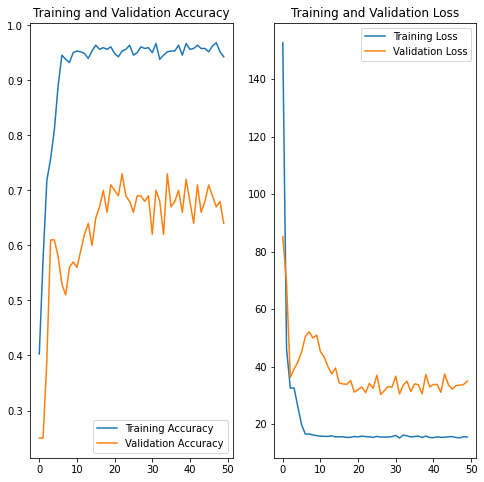

In [154]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

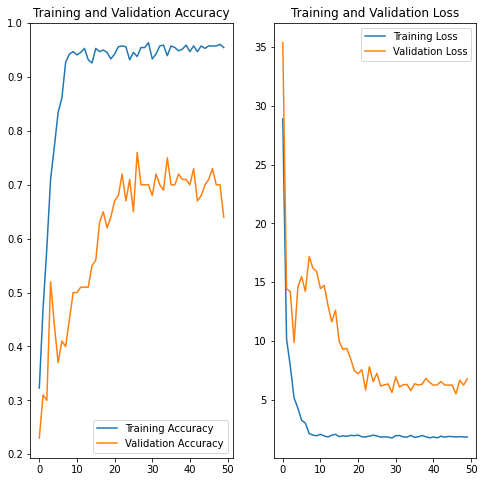

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#128 64 32

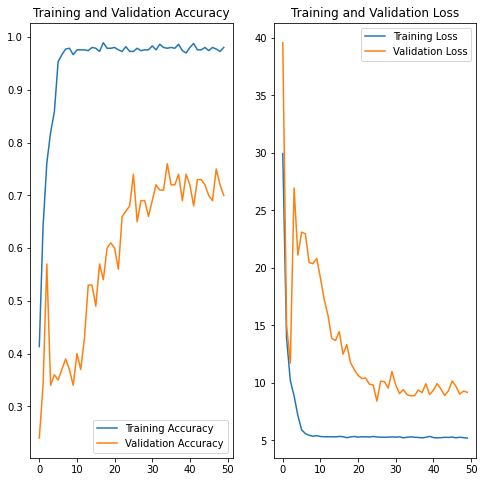

In [23]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#32 64 128 256
#Reg 0.2

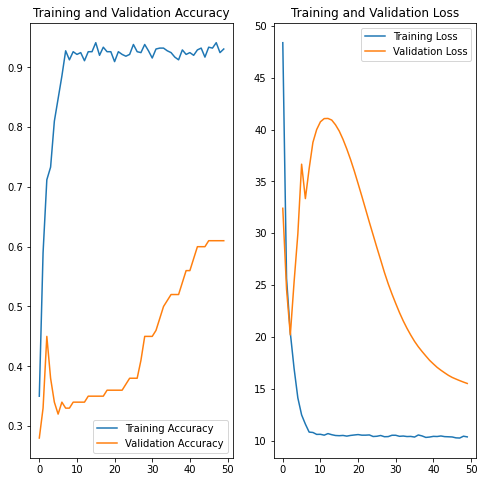

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#32 64 128 256 Dense More regularizaition 0.35

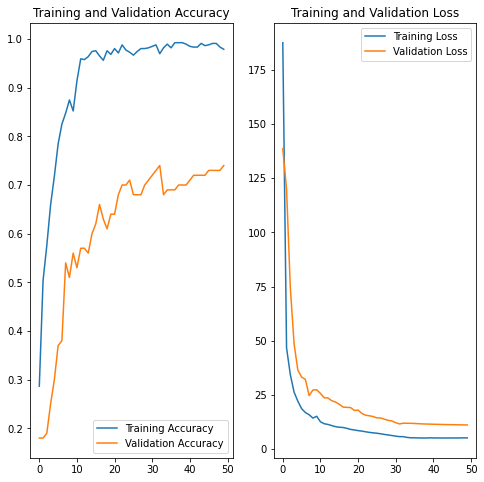

In [44]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#32 64 Dene 256

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


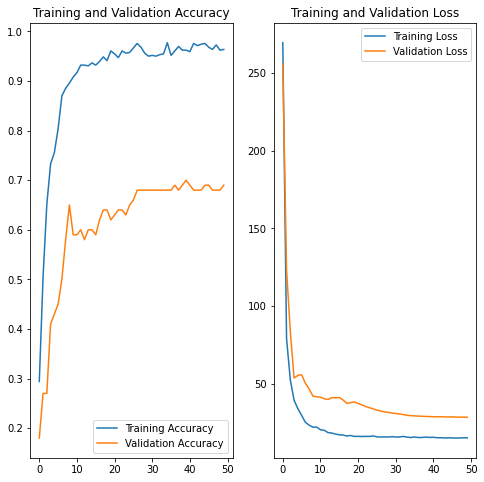

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#32 64 Dene 256 with more frames

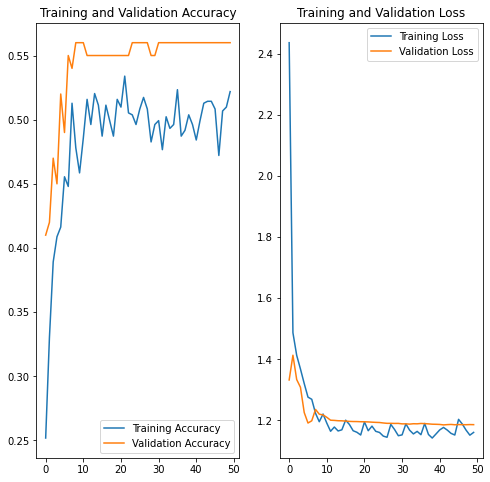

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#LSTM

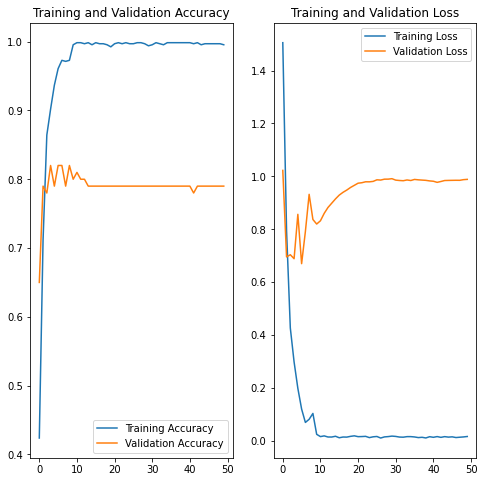

In [37]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#GRU

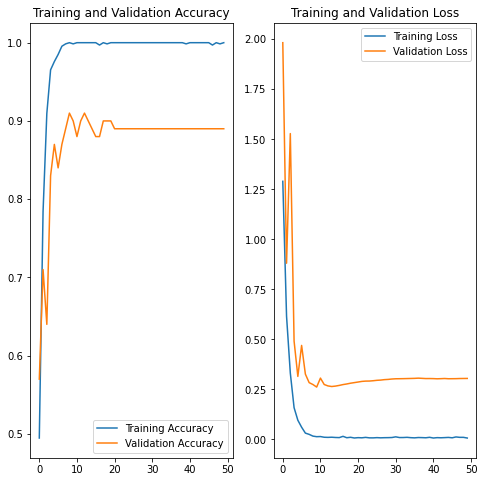

In [34]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#GRU 64 128

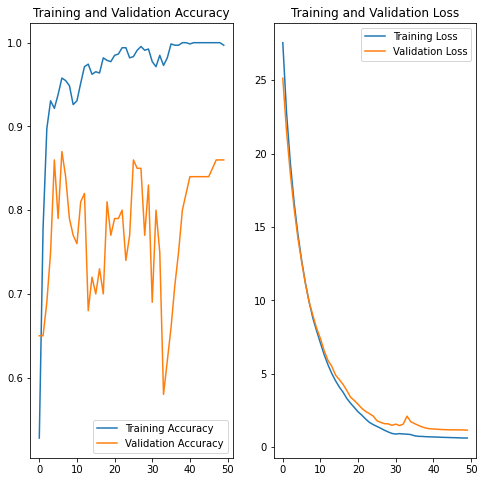

In [51]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#GRU 64 128 and Inialization

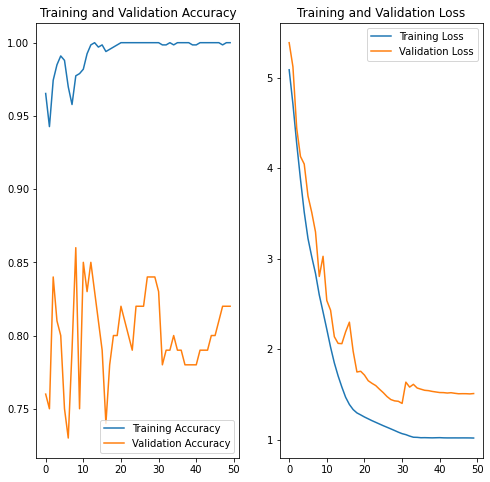

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#GRU and INitialization 

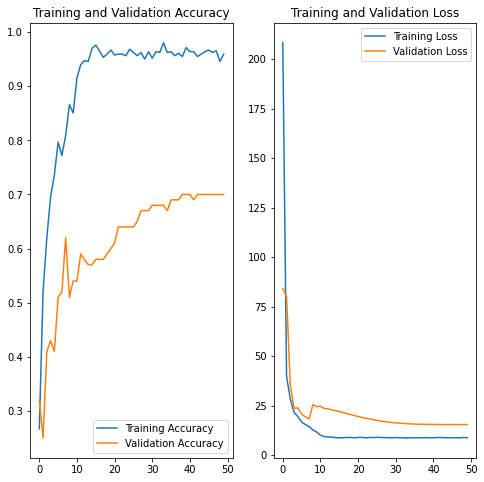

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

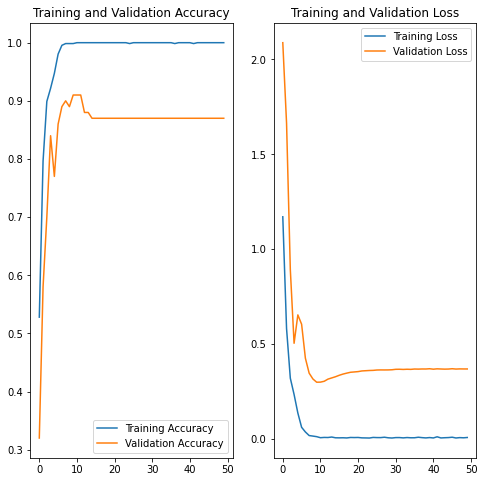

In [49]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

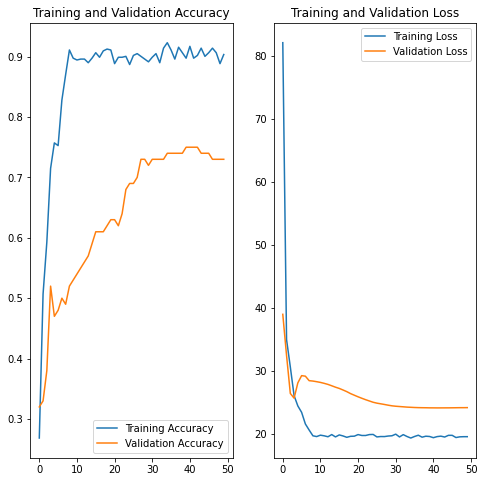

In [63]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()